In [64]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import datetime

from scipy import stats
from itertools import product
from dateutil.relativedelta import relativedelta

%matplotlib inline
warnings.filterwarnings('ignore')

In [53]:
# Реализуем функцию для обратного преобразования Бокса-Кокса
def box_cox_transformation(lmbda, series):
    if lmbda == 0:
        return(np.exp(series))
    else:
        return(np.exp(np.log(lmbda*series+1)/lmbda))

### Основные задания:
- Визуальный анализ ряда
- Стабилизация дисперсии (при необходимости)
- Выбор порядка дифференцирования
- Выбор начальных приближений для ```p, q, P, Qp, q, P, Q```
- Обучение и сравнение моделей-кандидатов, выбор победителя
- Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения ```p, q, P, Qp, q, P, Q```
- Прогнозирование с помощью финальной модели (построить прогноз на каждый месяц на два года вперёд от конца данных)

### Загрузка и визуализация ряда

In [11]:
data = pd.read_csv('avg_salary_russia.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.columns = ['avg_salary']
data.head()

,avg_salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


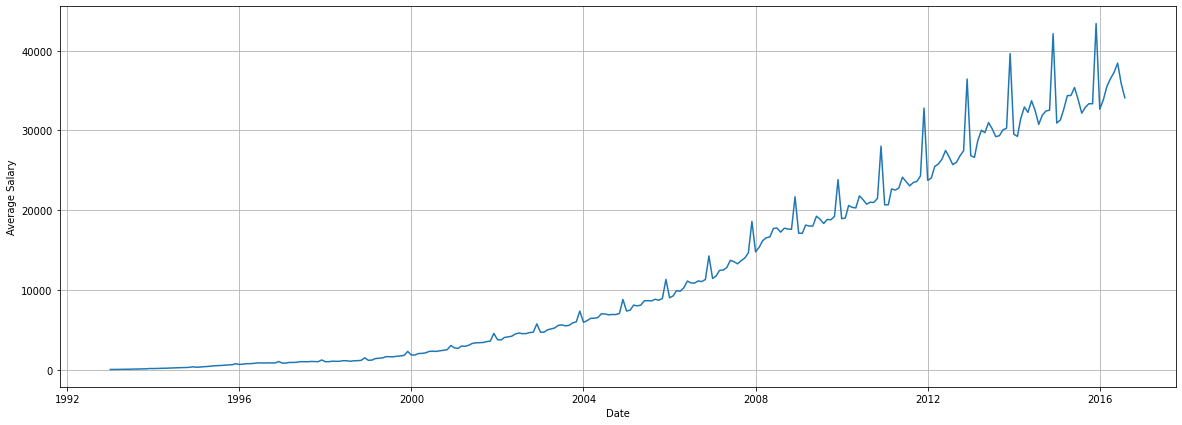

In [13]:
# Для визуализации ВР
def plot_sereis(series):
    plt.figure(figsize=(20,7))
    plt.plot(series)
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Average Salary')
    
plot_sereis(data['avg_salary'])

Такой ряд явно не является стационарным, оценим формально, применив критерий Дики-Фуллера

In [14]:
print("Diki-Fuller Criterion: p=%f" % sm.tsa.stattools.adfuller(data['avg_salary'])[1])

Diki-Fuller Criterion: p=0.991850


Действительно, нулевая гипотеза о нестационарном временном ряде не отвергается. Взглянем на STL - декомпозицию:

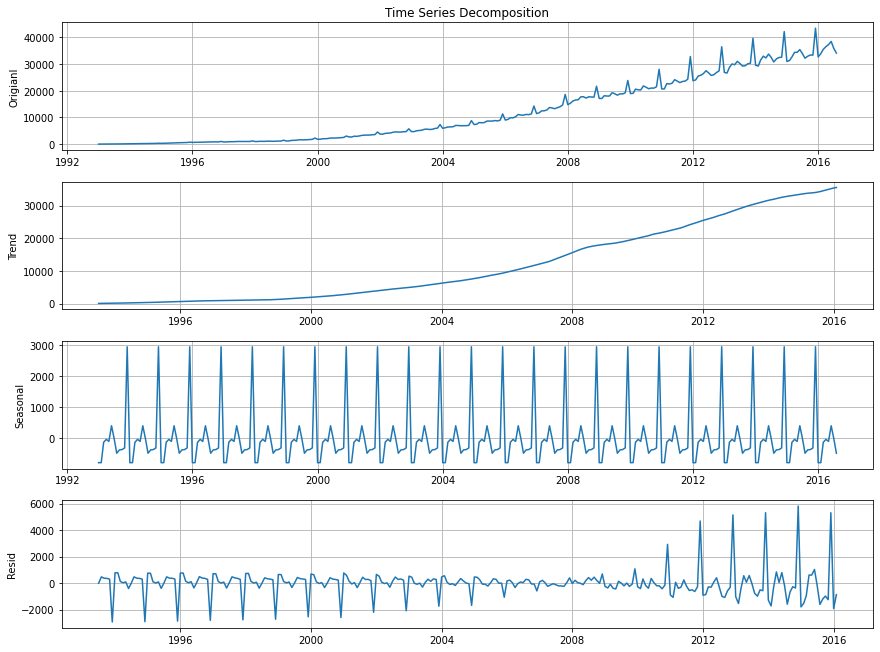

In [15]:
# Создадим удобную функцию для декомпозиции ряда 
def plot_decomposition(series, figsize = (12, 9), grid=True):
    ts_compnts = sm.tsa.seasonal_decompose(series)
    titles = ['Origianl', 'Trend', 'Seasonal', 'Resid']

    fig, ax = plt.subplots(nrows=4, ncols=1,figsize=figsize)
    plt.tight_layout()
    ax[0].set_title('Time Series Decomposition')
    
    ax[0].plot(series)
    ax[1].plot(ts_compnts.trend)
    ax[2].plot(ts_compnts.seasonal)
    ax[3].plot(ts_compnts.resid)
    
    for indx, title in enumerate(titles):
        ax[indx].set_ylabel(title)
        ax[indx].grid(True)
        
plot_decomposition(data['avg_salary'])

Анализ временного ряда показывает, что сильно выражен нелинейный возрастающий тренд. Дисперсия ряда нестабильна (небольшая в самом начале, затем плавно увеличивается. Неудевительно, ведь средняя заработная плата растет. Сезонная компонента также присутствует и ярко выражена (длина сезона 12 месяцев). Остатки смещенные и нестационарные.

### Стабилизация дисперсии ряда

Дисперсия нашего ряда нестационарна, стабилизируем её методом Бокса-Кокса, использовав готовую реализацию. Стабилизация дисперсии не приведет к стационарности, так как мы имеем тренд и сезонность.

In [18]:
data['avg_salary_box_cox'], lmbda = stats.boxcox(data['avg_salary'])
print("Optimal Lambda: %f" %lmbda)

Optimal Lambda: 0.263202


Взглянем на ряд со стабилизированной дисперсией

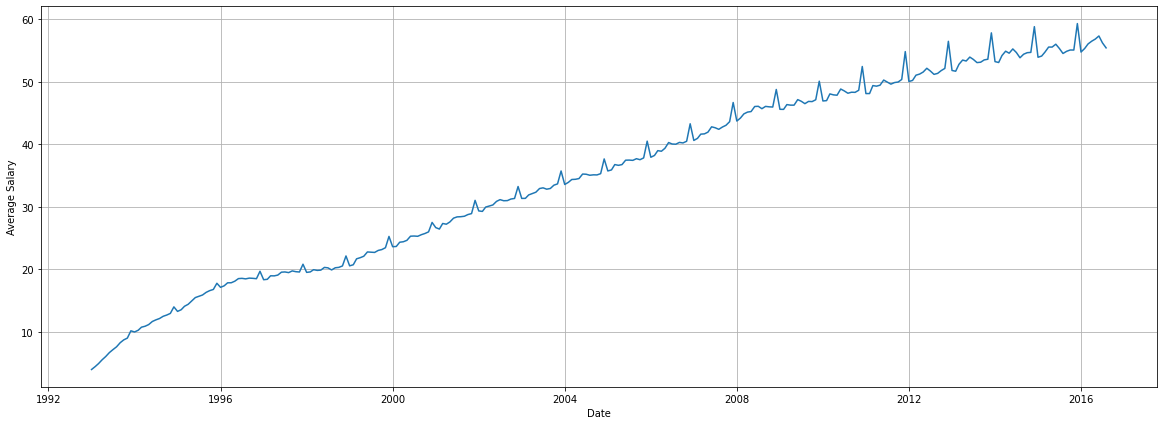

In [19]:
plot_sereis(data['avg_salary_box_cox'])

Отлично, можно заметить как незначительно стал колебаться ряд.

### Получение стационарности
Так как в ряде присутствует сезонная компонента, то применим сезонное дифференцирование. Как было уже сказано, длина сезона 12 месяцев

In [20]:
data['avg_salary_box_cox_seas_diff'] = data['avg_salary_box_cox'] - data['avg_salary_box_cox'].shift(12)

Взглянем на STL - декомпозицию для продифференцированного ряда (NaN значения нужно отрезать)

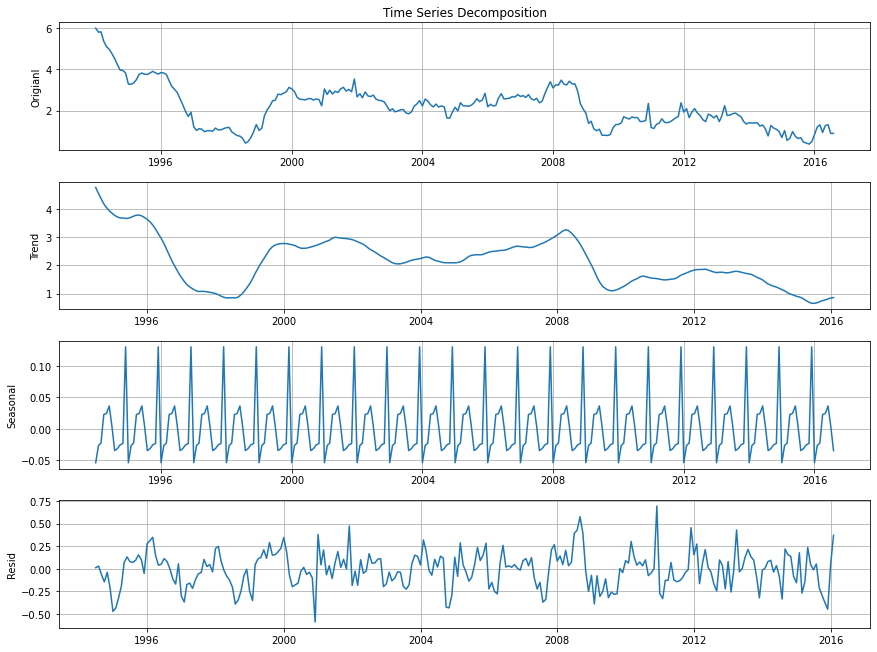

In [21]:
plot_decomposition(data['avg_salary_box_cox_seas_diff'][12:])

Сезонные разности помогли сделать ряд лучше. Тренд уже не так ярко выражен, однако все еще нелинейный и колеблется. Взглянем на критерий Дики-Фуллера. Даже если он отвергнет нулевую гипотезу, то мы все равно применим первый разности, ряд явно еще нестационарный.

In [22]:
print("Diki-Fuller Criterion: p=%f" % sm.tsa.stattools.adfuller(data['avg_salary_box_cox_seas_diff'][12:])[1])

Diki-Fuller Criterion: p=0.014697


Не будем слепо верить критерию, применим первые разности

In [23]:
data['avg_salary_box_cox_seas_diff_1'] = data['avg_salary_box_cox_seas_diff'] - data['avg_salary_box_cox_seas_diff'].shift(1)

Снова взглянем на STL - декомпозицию после применения сезонных и первых разностей

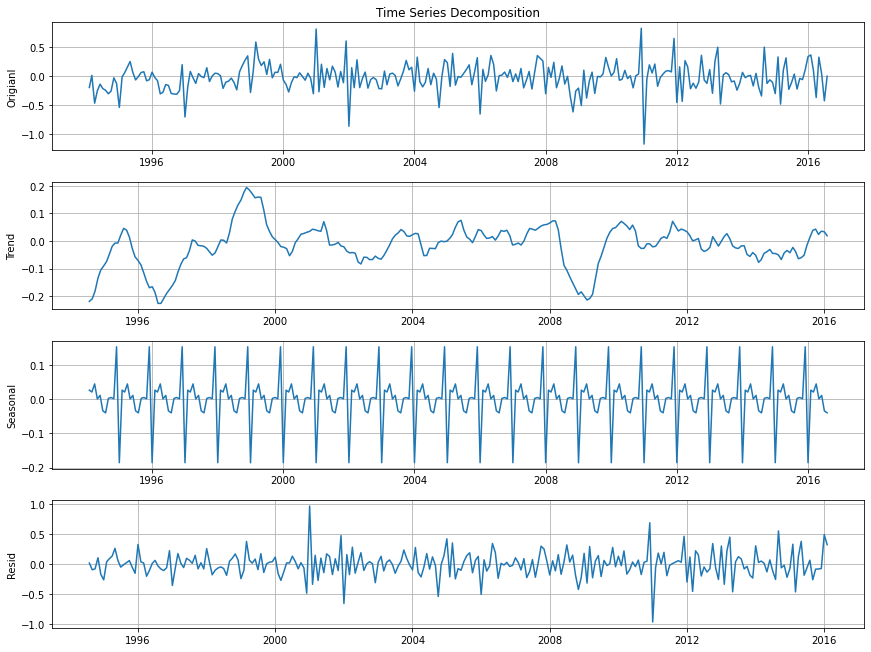

In [24]:
plot_decomposition(data['avg_salary_box_cox_seas_diff_1'][13:])

Замечательно, теперь тренд линейный и колеблется около нуля. Остатки похожи на белый шум и стационарны. Такой ряд явно стационарен. Проверим формально.

In [25]:
print("Diki-Fuller Criterion: p=%f" % sm.tsa.stattools.adfuller(data['avg_salary_box_cox_seas_diff_1'][13:])[1])

Diki-Fuller Criterion: p=0.000000


Критерий Дики-Фуллера уверенно отвергает нулевую гипотезу. Ряд приведен к стационарности.

### Модель ARIMA и начаьные приближения параметров
Определим параметры p,P,q,Q по графикам ACF и PACF

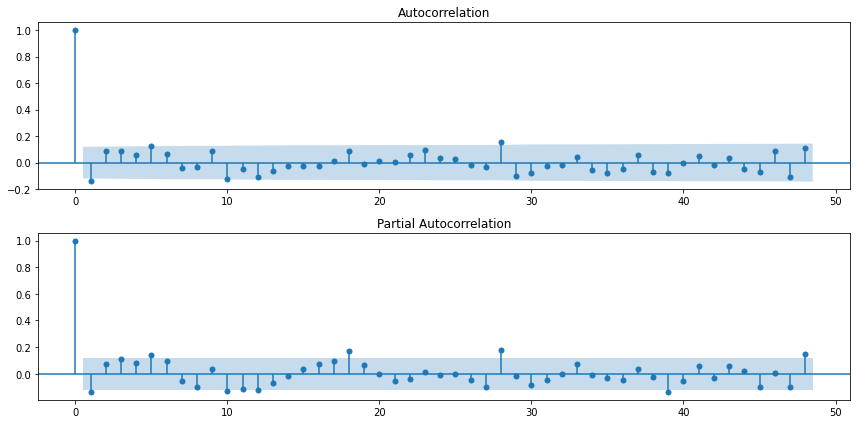

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
sm.graphics.tsa.plot_acf(data['avg_salary_box_cox_seas_diff_1'][13:].values.squeeze(), lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(data['avg_salary_box_cox_seas_diff_1'][13:].values.squeeze(), lags=48, ax=ax[1])
plt.tight_layout()

По графику ACF будем определять начальные приближения q и Q:
- Q: 0 (максимальный сезонный лаг который значим, учитывая длину сезона)
- q: 1 (максимальный несозонный лаг который значим)

По графику PACF будем определять начальные приближения для p и P:
- P: 4 (максимальный сезонный лаг который значим, учитывая длину сезона, 48 лаг значим: ```48/12=4```)
- p: 5 (максимальный несозонный лаг который значим)

Учитывая теперь наши начальные приближения осуществим перебор данных параметров для модели

In [43]:
# Начальные приближения
Q = range(0,1) 
q = range(0,1) # 0-1

p = range(0,5) # 0-4
P = range(0,6) # 0-5

D = 1 # сезооные разности были применены 1 раз
d = 1 # первые разности были применены 1 раз
s = 12 # 

In [44]:
# Взглянем на общее число комбинаций
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print('Total Params Combinations: ', len(parameters_list))

Total Params Combinations:  30


### Обучаем SARIMA

In [45]:
%%time

results = []
best_aic = float('inf')

for param in parameters_list:
    # Т.к. моедель не обучается на некоторых параметрах, то заключим критичный код в try-except блок
    try:
        model = sm.tsa.statespace.SARIMAX(data['avg_salary_box_cox'],
                                          order=(param[0], d, param[1]), # p,d,q params
                                          seasonal_order=(param[2], D, param[3], s) # P, D, Q, s params
                                         ).fit(disp=-1)
        
    # Если модель не обучается на каких-то параметрах, выводим их 
    except ValueError:
        print('Wrong Params: ', param)
        continue
        
    # Смотрим на значения информационного критерия Акайке и сохраняем лучшую модель 
    current_aic = model.aic
    if current_aic < best_aic:
        best_model = model
        best_aic = current_aic
        best_param = param
        
    results.append([param, current_aic])

Wall time: 51.3 s


In [46]:
# Результаты 
modesl_results = pd.DataFrame(results)
modesl_results.columns = ['params', 'aic']

# Выводим топ-5 лучших 
modesl_results.sort_values(by='aic').head()

,params,aic
29,"(4, 0, 5, 0)",-1.266308
25,"(4, 0, 1, 0)",-0.583149
19,"(3, 0, 1, 0)",-0.341050
7,"(1, 0, 1, 0)",0.340521
23,"(3, 0, 5, 0)",0.569538


In [47]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                 avg_salary_box_cox   No. Observations:                  284
Model:             SARIMAX(4, 1, 0)x(5, 1, 0, 12)   Log Likelihood                  10.633
Date:                            Sat, 20 Feb 2021   AIC                             -1.266
Time:                                    22:37:00   BIC                             34.755
Sample:                                01-01-1993   HQIC                            13.197
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1330      0.052     -2.562      0.010      -0.235      -0.031
ar.L2          0.0517      0.070   

Видим, что не все коэффициенты модели значимы, однако критреий Ljung-Box говорит что остатки не являются автокоррелированными, что хорошо.

Сделаем визуальный анализ остатков модели

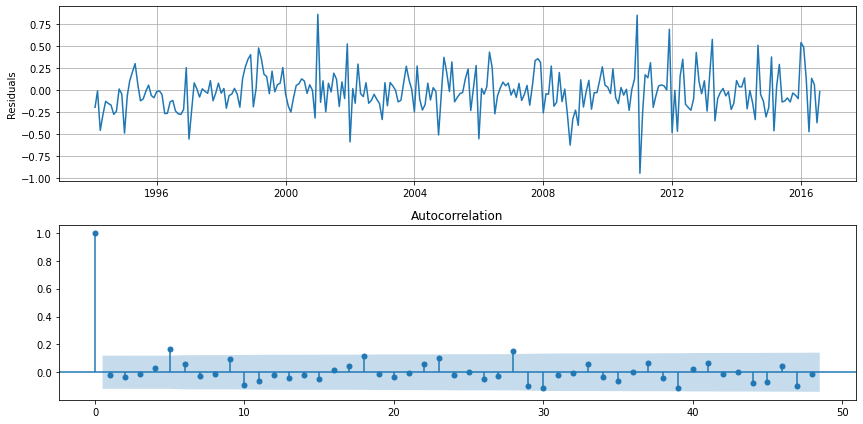

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
ax[0].plot(best_model.resid[13:])
ax[0].grid(True)
ax[0].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax[1])
plt.tight_layout()

In [51]:
print("Diki-Fuller Criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
print("Student's Criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])

Diki-Fuller Criterion: p=0.000000
Student's Criterion: p=0.341334


Анализ показал, что остатки:

- Несмещены (подтверждается критерием Стьюдента) 
- Неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой)
- Стационарны (критерий Дики-Фуллера)

Взглянем теперь как хорошо модель описывает данные, применив обратное преобразование Бокса-Кокса

In [54]:
data['model_pred'] = box_cox_transformation(series=best_model.fittedvalues, lmbda=lmbda)

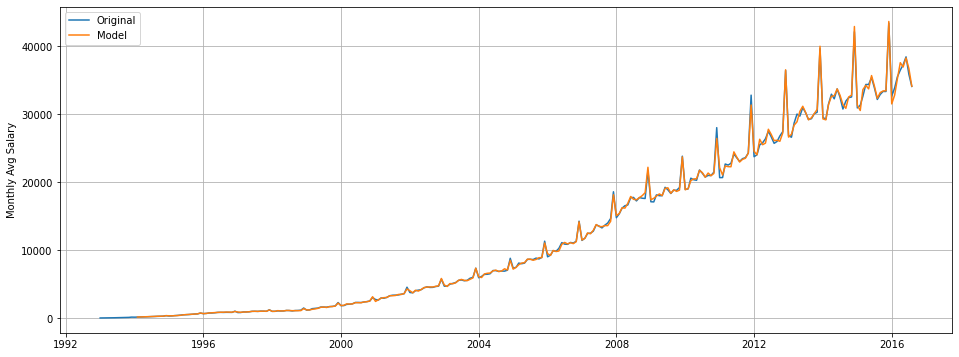

In [58]:
plt.figure(figsize=(16, 6))
plt.plot(data['avg_salary'], label='Original')
plt.plot(data['model_pred'][13:], label='Model')
plt.ylabel('Monthly Avg Salary')
plt.legend()
plt.grid(True);

Видно, что модель очень хорошо улавливает основные закономерности. Модель хороша

### Прогнозирование

In [65]:
# Отбираем основной ряд и оформляем как df
origianl_series = data[['avg_salary']]

# Создадим наше окно предсказаний, например, на 3 года (36 месяцев)
dates_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)] 

# Объединяем датафреймы для получения горизонта предсказаний
preds_df = pd.DataFrame(index=dates_list, columns=origianl_series.columns)
origianl_series = pd.concat([origianl_series, preds_df])
origianl_series

,avg_salary
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2018-03-01,NaN
2018-04-01,NaN
2018-05-01,NaN
2018-06-01,NaN


In [69]:
forecast = best_model.predict(start=284, end=308) # start - последние известное значение для исходного ряда

# Т.к. наша модель настроена на значения преобразованные методом Бокса-Кокса то
# предсказания необходимо преобразовать обратно (т.е. сделать обратное преобразование Бокса-Кокса)
origianl_series['model_forecast'] = box_cox_transformation(series=forecast, lmbda=lmbda)

### Прогноз средней зарплаты на 3 года в России 

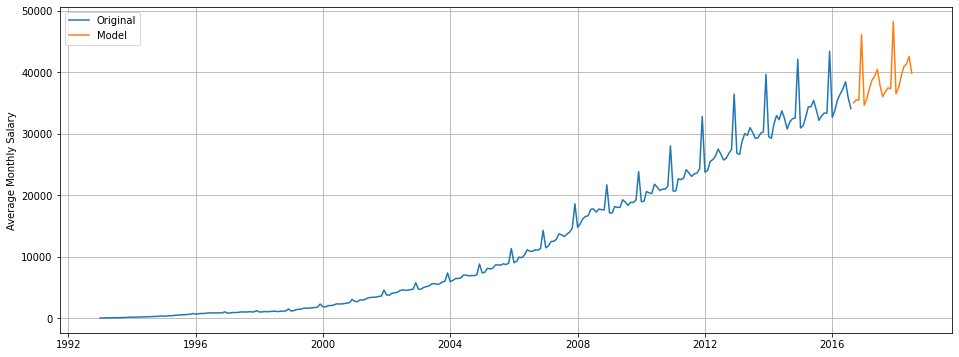

In [72]:
plt.figure(figsize=(16, 6))
plt.plot(origianl_series['avg_salary'], label='Original')
plt.plot(origianl_series['model_forecast'], label='Model')
plt.ylabel('Average Monthly Salary')
plt.grid(True)
plt.legend();

Прогноз модели выглядит адекватным, передает сезонность и даже возрастающий тренд.